# Dự đoán Doanh thu Bán Lẻ


## 1. Giới Thiệu Và Cài Đặt Tài Nguyên

In [77]:
# # Cài đặt các thư viện cần thiết
# install.packages("dplyr")
# install.packages("lubridate")

In [78]:
# install.packages("bnlearn")

In [79]:
# install.packages("caret")

In [80]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install(c("graph", "Rgraphviz"), update=FALSE)

In [121]:
if(!require(corrplot)) install.packages("corrplot")
if(!require(DescTools)) install.packages("DescTools", dependencies=TRUE)

Loading required package: corrplot

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘corrplot’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: DescTools


Attaching package: ‘DescTools’


The following objects are masked from ‘package:caret’:

    MAE, RMSE




In [122]:
# @title
library(readxl)
library(dplyr)
library(lubridate)
library(bnlearn)
library(Rgraphviz)
library(caret)
library(corrplot)
library(DescTools)

corrplot 0.95 loaded



## 2. Chuẩn Bị Dữ Liệu

### 2.1. Tải Dữ Liệu

In [125]:
file_path <- "doanhthu.xls"
df <- read_excel(file_path, col_names = TRUE)

In [126]:
df

Giờ,Giảm giá,Doanh thu thuần,Giá trị đơn hàng trung bình
<dttm>,<dbl>,<dbl>,<dbl>
2025-02-16 00:00:00,0,0,0.0
2025-02-16 01:00:00,0,0,0.0
2025-02-16 02:00:00,0,0,0.0
2025-02-16 03:00:00,0,0,0.0
2025-02-16 04:00:00,0,0,0.0
2025-02-16 05:00:00,0,0,0.0
2025-02-16 06:00:00,0,0,0.0
2025-02-16 07:00:00,0,0,0.0
2025-02-16 08:00:00,0,0,0.0


### 2.2. Làm Sạch Dữ Liệu

In [83]:
if (ncol(df) == 3) {
  names(df) <- c("Timestamp", "Discount", "NetRevenue")
  df$AvgTransactionValue <- ifelse(df$NetRevenue > 0, df$NetRevenue, 0)
} else {
  names(df) <- c("Timestamp", "Discount", "NetRevenue", "AvgTransactionValue")
}

df <- df %>%
  mutate(
    Hour = hour(Timestamp),
    TimeOfDay = case_when(
      hour(Timestamp) >= 5 & hour(Timestamp) < 12  ~ "Morning",
      hour(Timestamp) >= 12 & hour(Timestamp) < 18 ~ "Afternoon",
      TRUE ~ "Evening"
    ),
    DayType = ifelse(wday(Timestamp, label = TRUE, abbr = FALSE) %in% c("Friday","Saturday", "Sunday"), "Weekend", "Weekday"),
    Date = as.Date(Timestamp)
  )

all_special_dates_2025 <- as.Date(c(
  "2025-01-01", "2025-01-28", "2025-01-29", "2025-01-30", "2025-01-31",
  "2025-02-01", "2025-02-02", "2025-02-03", "2025-04-07", "2025-04-30",
  "2025-05-01", "2025-09-02", "2025-02-12", "2025-02-14", "2025-03-08",
  "2025-05-31", "2025-08-08", "2025-10-06"
))

df_filtered <- df %>%
  filter(NetRevenue > 0 | (Hour >= 8 & Hour < 21))

positive_revenue <- df_filtered$NetRevenue[df_filtered$NetRevenue > 0]
revenue_breaks <- quantile(positive_revenue, probs = c(0, 0.333, 0.666, 1), na.rm = TRUE)

positive_avg_txn <- df_filtered$AvgTransactionValue[df_filtered$AvgTransactionValue > 0]
avg_txn_breaks <- quantile(positive_avg_txn, probs = c(0, 0.333, 0.666, 1), na.rm = TRUE)

df_final <- df_filtered %>%
  mutate(
    HasDiscount = factor(Discount != 0, levels = c(FALSE, TRUE), labels = c("No", "Yes")),
    IsHoliday = factor(Date %in% all_special_dates_2025),
    AvgTxnValueCategory = case_when(
        AvgTransactionValue <= 0 ~ "Zero",
        AvgTransactionValue > avg_txn_breaks[3] ~ "High",
        AvgTransactionValue > avg_txn_breaks[2] ~ "Medium",
        TRUE ~ "Low"
    ),
    RevenueCategory = case_when(
      NetRevenue <= 0 ~ "Zero",
      NetRevenue > revenue_breaks[3] ~ "High",
      NetRevenue > revenue_breaks[2] ~ "Medium",
      TRUE ~ "Low"
    )
  )

## 3. Phân Tích Khám Phá (EDA)

In [127]:
df_final

Timestamp,Discount,NetRevenue,AvgTransactionValue,Hour,TimeOfDay,DayType,Date,HasDiscount,IsHoliday,AvgTxnValueCategory,RevenueCategory
<dttm>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<date>,<fct>,<fct>,<chr>,<chr>
2025-02-16 08:00:00,0,0,0.0,8,Morning,Weekend,2025-02-16,No,FALSE,Zero,Zero
2025-02-16 09:00:00,0,0,0.0,9,Morning,Weekend,2025-02-16,No,FALSE,Zero,Zero
2025-02-16 10:00:00,0,1600000,1600000.0,10,Morning,Weekend,2025-02-16,No,FALSE,High,Medium
2025-02-16 11:00:00,0,0,0.0,11,Morning,Weekend,2025-02-16,No,FALSE,Zero,Zero
2025-02-16 12:00:00,-1210650,24954350,1678023.3,12,Afternoon,Weekend,2025-02-16,Yes,FALSE,High,High
2025-02-16 13:00:00,-523520,15175480,895851.8,13,Afternoon,Weekend,2025-02-16,Yes,FALSE,Medium,High
2025-02-16 14:00:00,0,0,0.0,14,Afternoon,Weekend,2025-02-16,No,FALSE,Zero,Zero
2025-02-16 15:00:00,0,0,0.0,15,Afternoon,Weekend,2025-02-16,No,FALSE,Zero,Zero
2025-02-16 16:00:00,0,0,0.0,16,Afternoon,Weekend,2025-02-16,No,FALSE,Zero,Zero


In [94]:
eda_data <- data.frame(
  HasDiscount = df_final$HasDiscount,
  TimeOfDay   = as.factor(df_final$TimeOfDay),
  DayType     = as.factor(df_final$DayType),
  IsHoliday   = df_final$IsHoliday,
  AvgTxnValueCategory = as.factor(df_final$AvgTxnValueCategory),
  RevenueCategory = as.factor(df_final$RevenueCategory)
)
eda_data <- droplevels(eda_data)

In [105]:
print("--- PHÂN TÍCH ĐƠN BIẾN ---")

[1] "--- PHÂN TÍCH ĐƠN BIẾN ---"


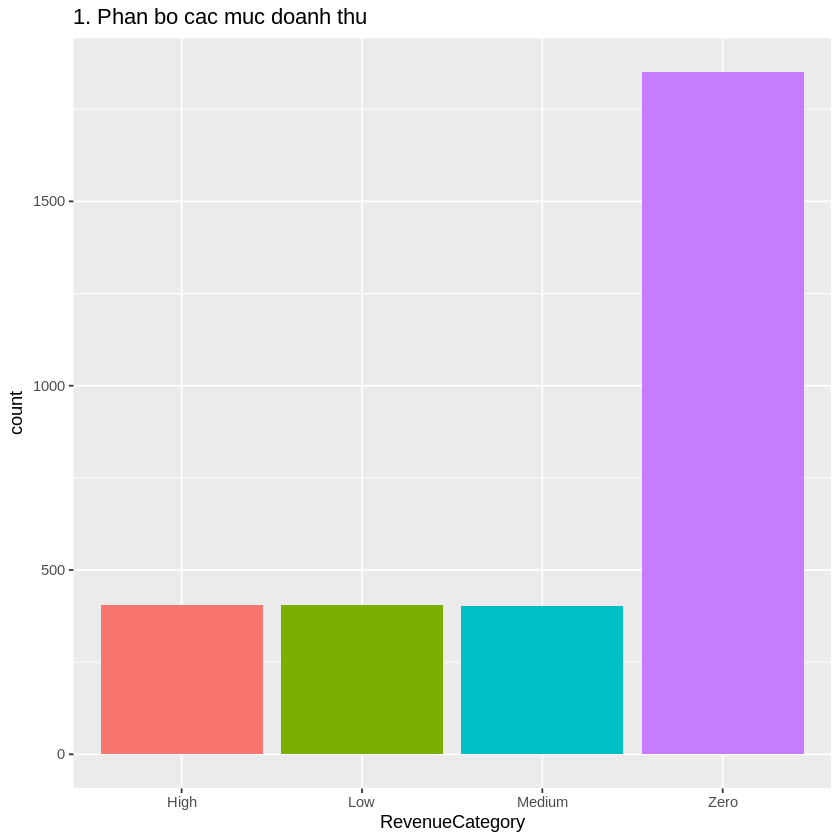

In [106]:
p1 <- ggplot(eda_data, aes(x = RevenueCategory, fill = RevenueCategory)) +
  geom_bar(show.legend = FALSE) + labs(title = "1. Phan bo cac muc doanh thu")
print(p1)

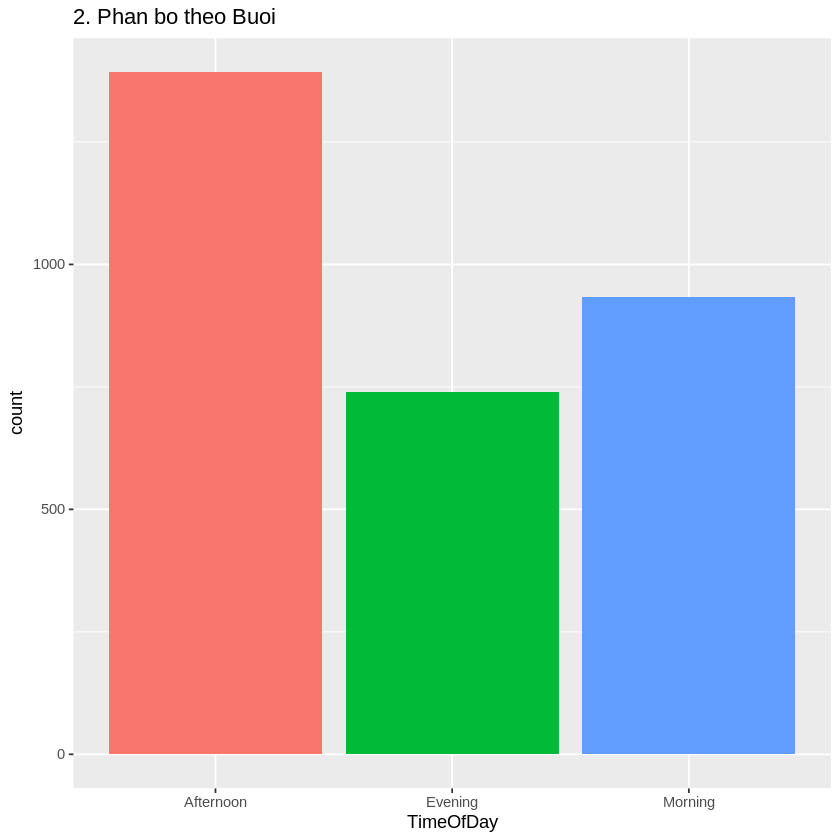

In [107]:
p2 <- ggplot(eda_data, aes(x = TimeOfDay, fill = TimeOfDay)) +
  geom_bar(show.legend = FALSE) + labs(title = "2. Phan bo theo Buoi")
print(p2)

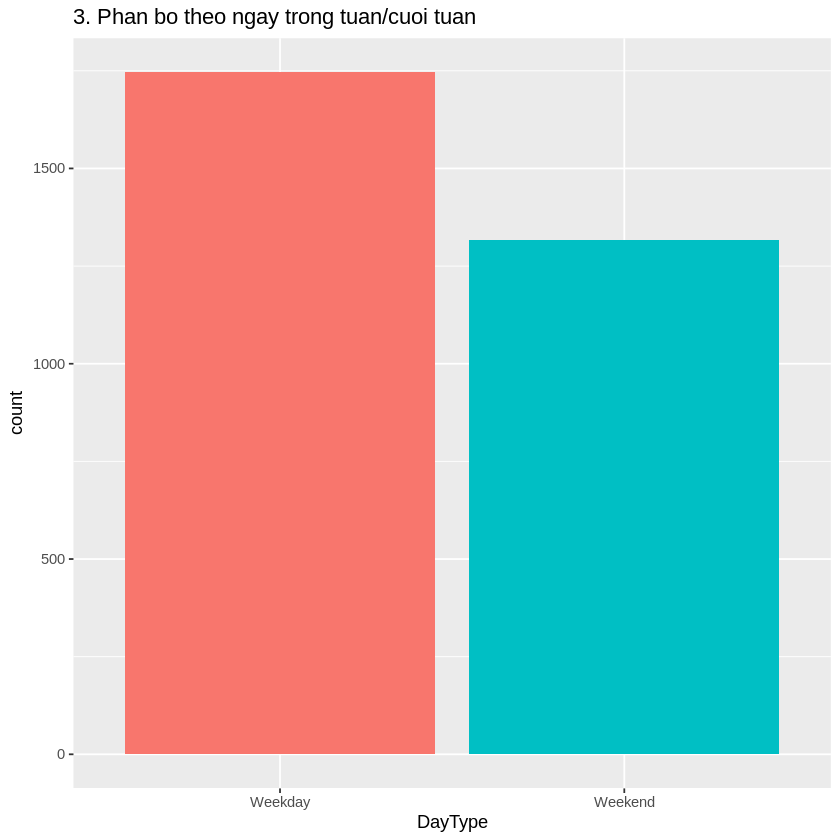

In [109]:
p3 <- ggplot(eda_data, aes(x = DayType, fill = DayType)) +
  geom_bar(show.legend = FALSE) + labs(title = "3. Phan bo theo ngay trong tuan/cuoi tuan")
print(p3)

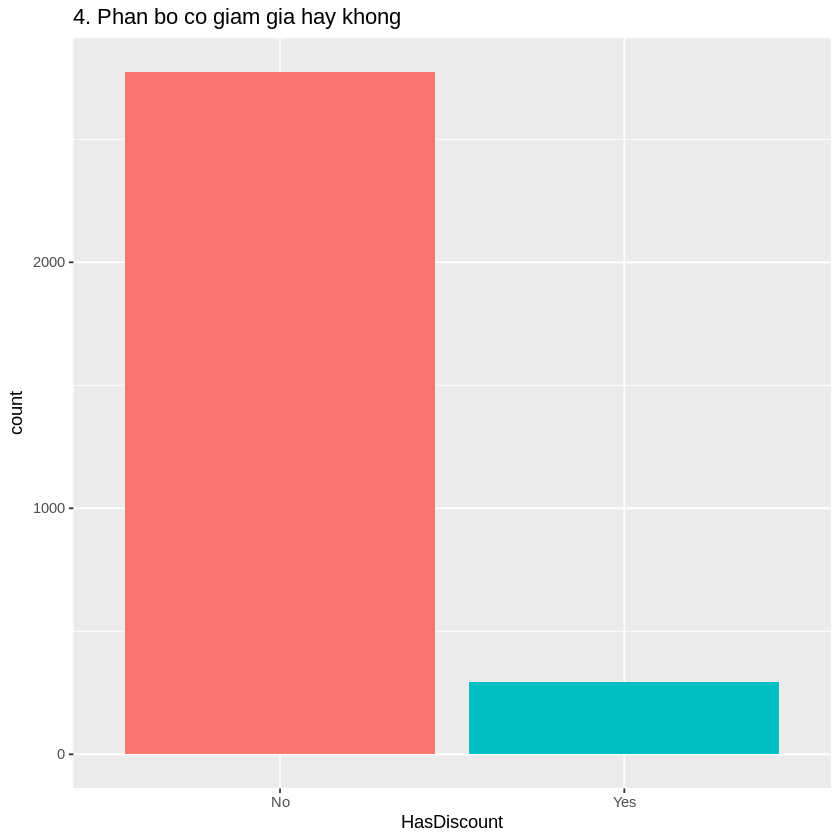

In [110]:
p4 <- ggplot(eda_data, aes(x = HasDiscount, fill = HasDiscount)) +
  geom_bar(show.legend = FALSE) + labs(title = "4. Phan bo co giam gia hay khong")
print(p4)

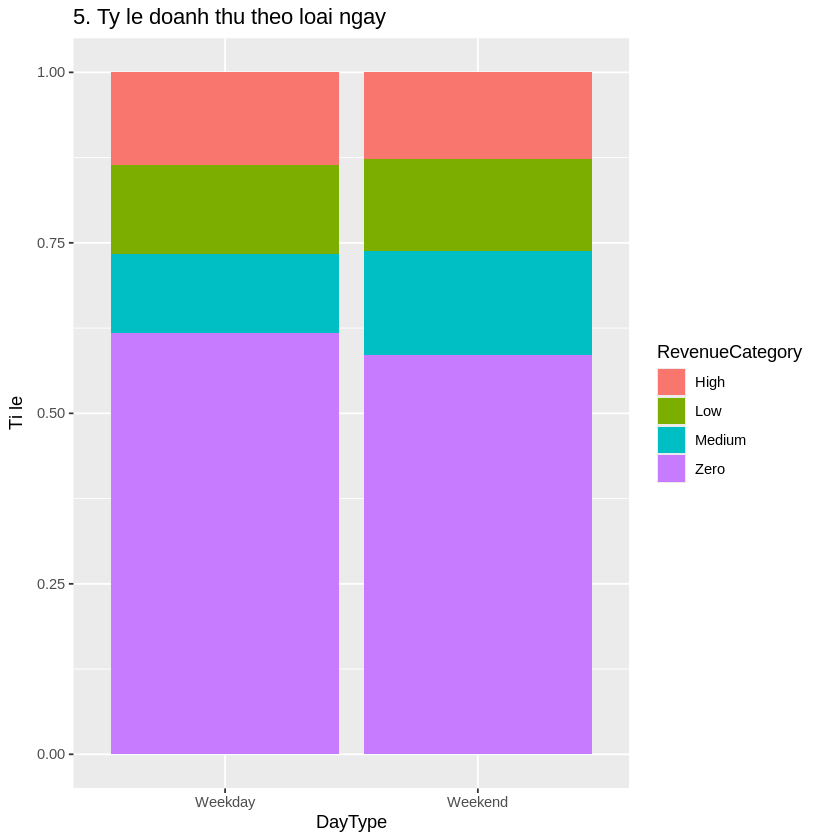

In [112]:
p5 <- ggplot(eda_data, aes(x = DayType, fill = RevenueCategory)) +
  geom_bar(position = "fill") +
  labs(title = "5. Ty le doanh thu theo loai ngay", y = "Ti le")
print(p5)

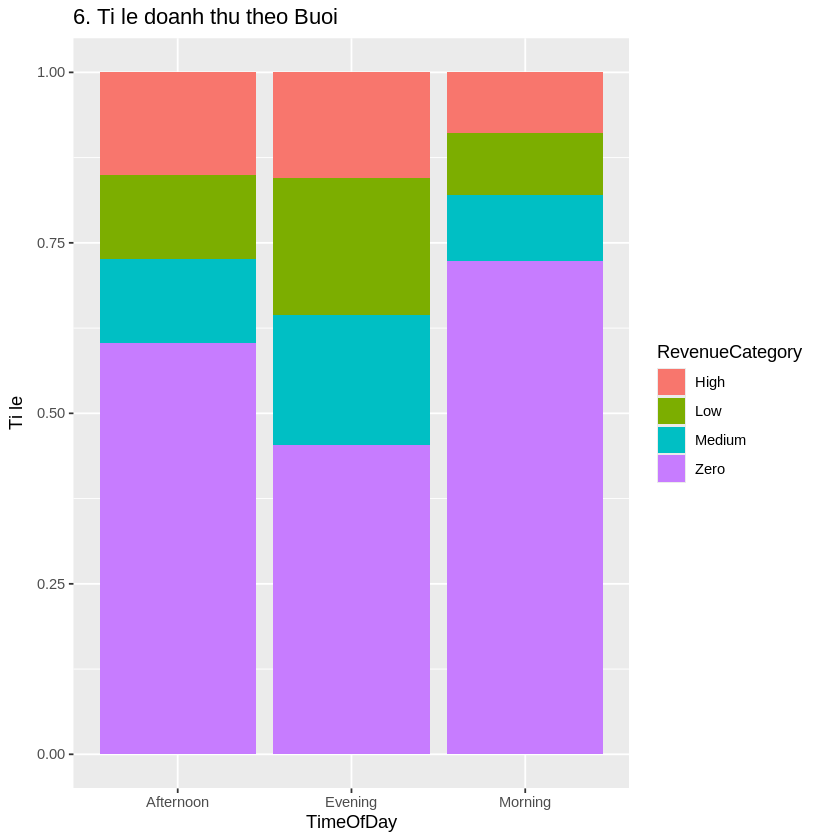

In [114]:
p6 <- ggplot(eda_data, aes(x = TimeOfDay, fill = RevenueCategory)) +
  geom_bar(position = "fill") +
  labs(title = "6. Ti le doanh thu theo Buoi", y = "Ti le")
print(p6)

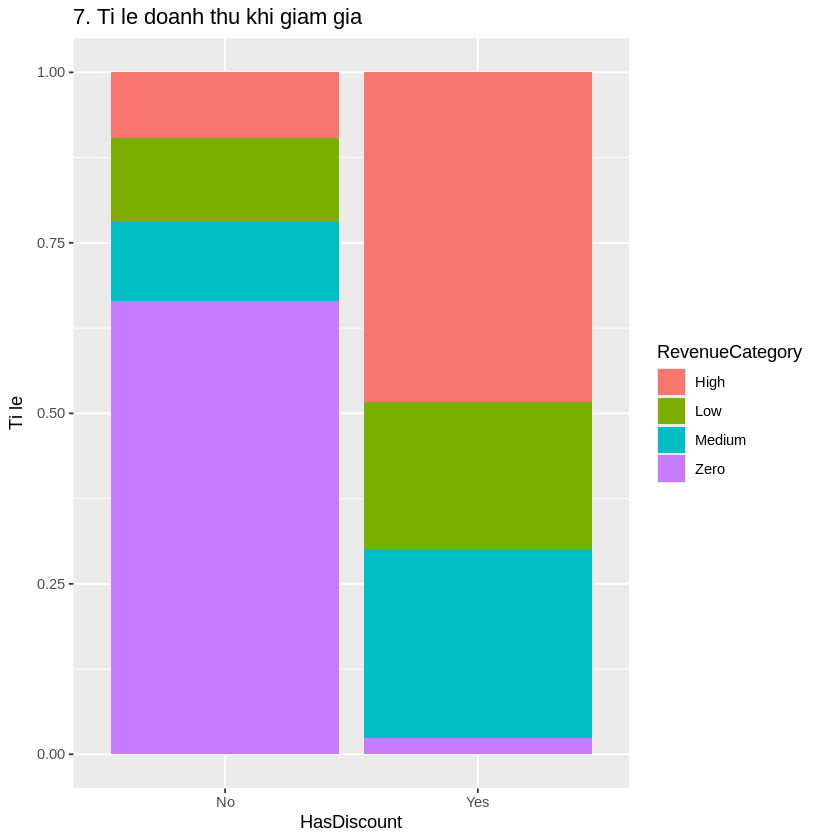

In [116]:
p7 <- ggplot(eda_data, aes(x = HasDiscount, fill = RevenueCategory)) +
  geom_bar(position = "fill") +
  labs(title = "7. Ti le doanh thu khi giam gia", y = "Ti le")
print(p7)

[1] "Ma trận liên kết (Cramer's V):"
                    HasDiscount TimeOfDay DayType IsHoliday AvgTxnValueCategory
HasDiscount               1.000     0.039   0.015     0.041               0.407
TimeOfDay                 0.039     1.000   0.002     0.004               0.157
DayType                   0.015     0.002   1.000     0.001               0.064
IsHoliday                 0.041     0.004   0.001     1.000               0.036
AvgTxnValueCategory       0.407     0.157   0.064     0.036               1.000
RevenueCategory           0.423     0.150   0.056     0.044               0.785
                    RevenueCategory
HasDiscount                   0.423
TimeOfDay                     0.150
DayType                       0.056
IsHoliday                     0.044
AvgTxnValueCategory           0.785
RevenueCategory               1.000
[1] "Đang vẽ biểu đồ nhiệt..."


Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"cl.lim" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"cl.lim" is not a graphical parameter”
Warning message in title(title, ...):
“"cl.lim" is not a graphical parameter”


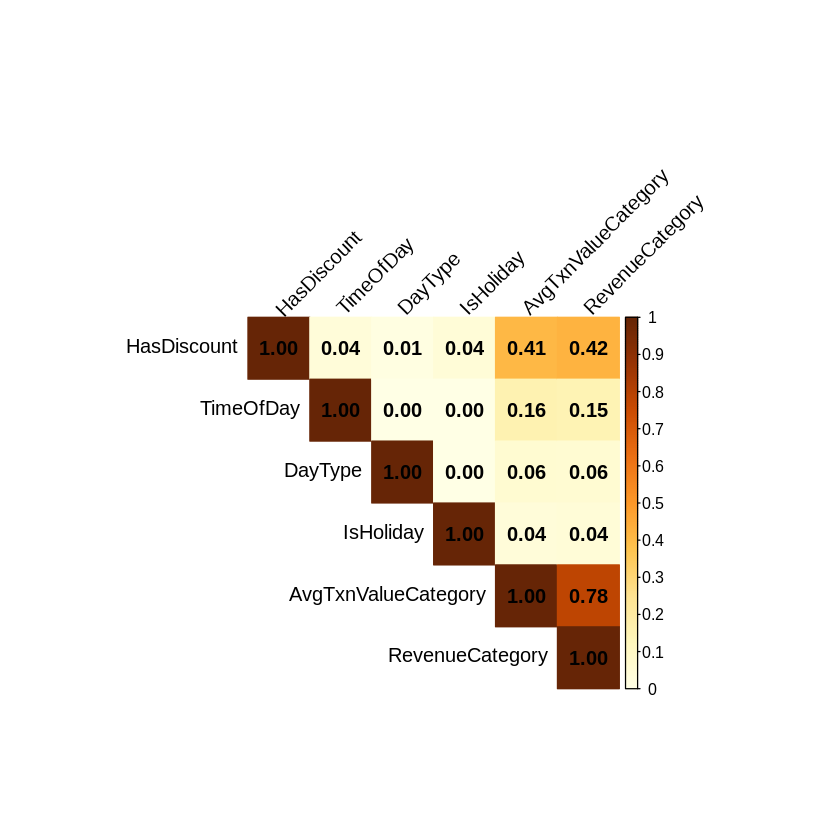

In [123]:
bn_data_final <- eda_data


# 2. Xây dựng ma trận Cramer's V một cách thủ công (Mạnh mẽ hơn)
# Lấy số lượng và tên các biến
num_vars <- ncol(bn_data_final)
var_names <- names(bn_data_final)

# Tạo một ma trận rỗng để lưu kết quả
cramer_matrix <- matrix(0, nrow = num_vars, ncol = num_vars,
                        dimnames = list(var_names, var_names))

# Dùng vòng lặp để tính Cramer's V cho từng cặp biến
for (i in 1:num_vars) {
  for (j in 1:num_vars) {
    # Tạo bảng tần suất chéo
    tbl <- table(bn_data_final[[i]], bn_data_final[[j]])

    # Tính Cramer's V từ bảng và gán vào ma trận
    cramer_matrix[i, j] <- CramerV(tbl)
  }
}

# Làm tròn kết quả cho dễ đọc
cramer_matrix <- round(cramer_matrix, 3)

print("Ma trận liên kết (Cramer's V):")
print(cramer_matrix)

# 3. Vẽ biểu đồ nhiệt (heatmap) cho ma trận
print("Đang vẽ biểu đồ nhiệt...")
corrplot(cramer_matrix,
         method = "color",
         type = "upper",
         is.corr = FALSE,
         tl.col = "black",
         tl.srt = 45,
         addCoef.col = "black",
         cl.lim = c(0, 1))

## 4. Xây Dựng Và Huấn Luyện Mô Hình

### 4.1 Mô hình với biến mục tiêu là root

[1] "Cấu trúc mạng cố định (Naive Bayes) đã được định nghĩa với đầy đủ biến:"

  Random/Generated Bayesian network

  model:
   [AvgTxnValueCategory][DayType][HasDiscount][IsHoliday][TimeOfDay]
   [RevenueCategory|AvgTxnValueCategory:DayType:HasDiscount:IsHoliday:TimeOfDay]
  nodes:                                 6 
  arcs:                                  5 
    undirected arcs:                     0 
    directed arcs:                       5 
  average markov blanket size:           5.00 
  average neighbourhood size:            1.67 
  average branching factor:              0.83 

  generation algorithm:                  Empty 

[1] "Đang vẽ đồ thị mạng cố định..."
[1] "Đang huấn luyện mô hình (có thể mất một chút thời gian)..."
[1] "--- Kết quả trên Test Set cho mô hình CỐ ĐỊNH (đầy đủ biến) ---"
[1] "=> Độ chính xác: 91.21%"


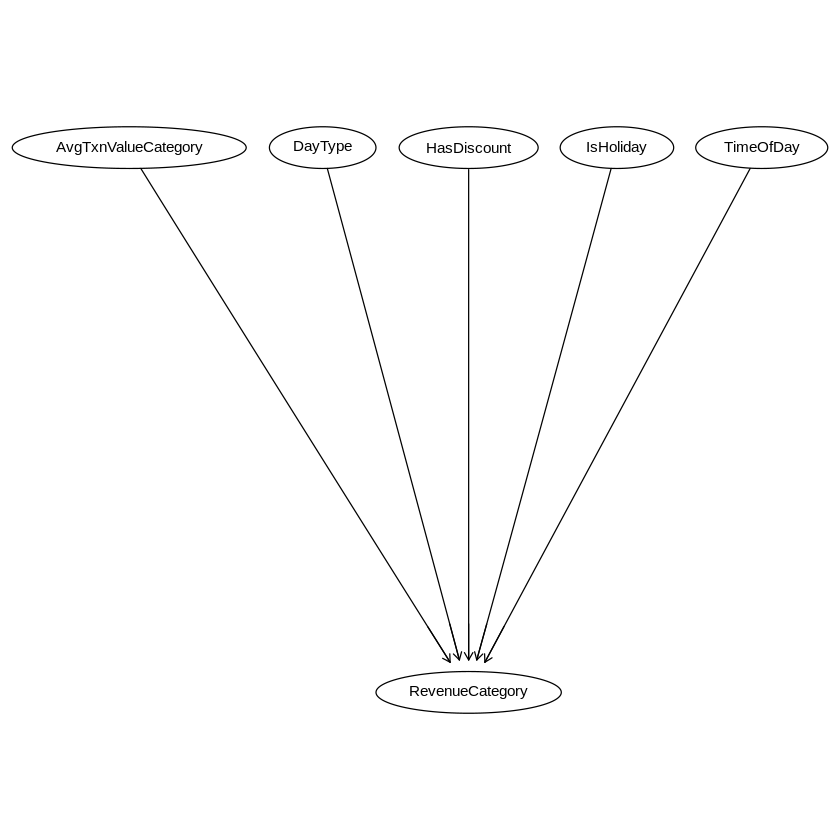

In [84]:
bn_data_final <- data.frame(
  HasDiscount = df_final$HasDiscount,
  TimeOfDay   = as.factor(df_final$TimeOfDay),
  DayType     = as.factor(df_final$DayType),
  IsHoliday = df_final$IsHoliday,
  AvgTxnValueCategory = as.factor(df_final$AvgTxnValueCategory),
  RevenueCategory = as.factor(df_final$RevenueCategory)
)
bn_data_final <- droplevels(bn_data_final)

set.seed(123)
train_indices <- sample(1:nrow(bn_data_final), size = 0.9 * nrow(bn_data_final))
training_set <- bn_data_final[train_indices, ]
test_set <- bn_data_final[-train_indices, ]

# Lấy tên tất cả các biến trừ biến mục tiêu
predictors <- setdiff(names(bn_data_final), "RevenueCategory")

# Tạo chuỗi định nghĩa cấu trúc tự động từ danh sách biến
fixed_structure_string <- paste0("[", paste(predictors, collapse="]["), "]",
                                 "[RevenueCategory|", paste(predictors, collapse=":"), "]")

# Chuyển chuỗi thành đối tượng mạng
fixed_bn_structure <- model2network(fixed_structure_string)

print("Cấu trúc mạng cố định (Naive Bayes) đã được định nghĩa với đầy đủ biến:")
print(fixed_bn_structure)

print("Đang vẽ đồ thị mạng cố định...")
graphviz.plot(fixed_bn_structure, shape = "ellipse")

print("Đang huấn luyện mô hình (có thể mất một chút thời gian)...")
fixed_model <- bn.fit(fixed_bn_structure, data = training_set)
predictions_fixed <- predict(fixed_model, node = "RevenueCategory", data = test_set)
accuracy_fixed <- sum(diag(table(predictions_fixed, test_set$RevenueCategory))) / nrow(test_set)

print("--- Kết quả trên Test Set cho mô hình CỐ ĐỊNH (đầy đủ biến) ---")
print(paste("=> Độ chính xác:", paste0(round(accuracy_fixed * 100, 2), "%")))

### 4.1 Mô hình với mạng chuyên gia

[1] "Đang vẽ đồ thị mạng Chuyên gia (đầy đủ biến)..."
[1] "Đang huấn luyện mô hình..."
[1] "--- Kết quả trên Test Set cho mô hình Mạng chuyên gia (đầy đủ biến) ---"
[1] "=> Độ chính xác: 92.51%"


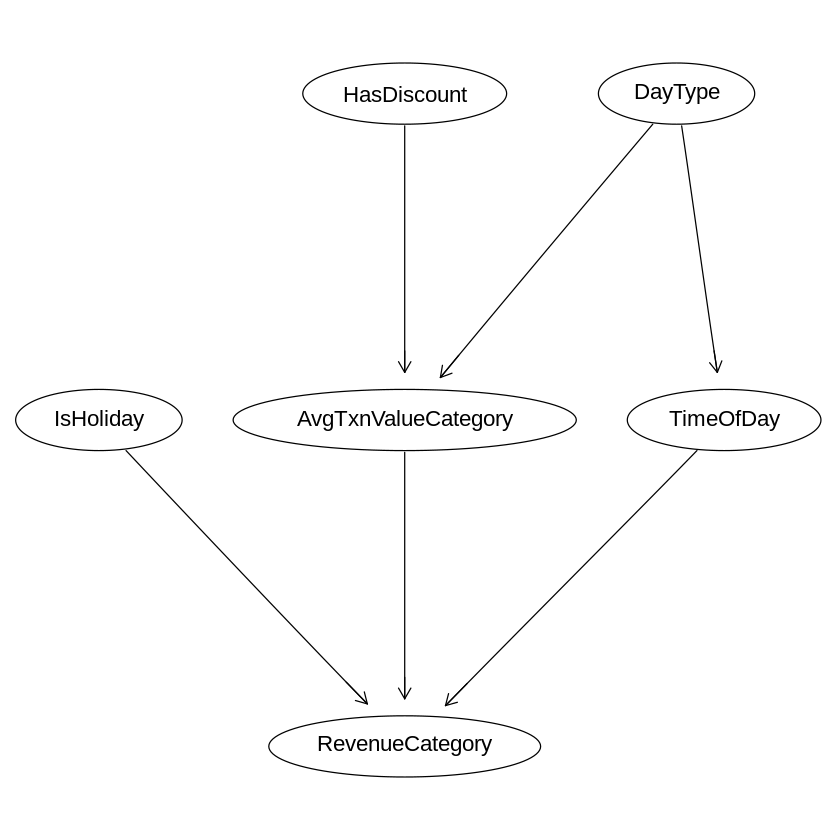

In [85]:
# 1. Chia dữ liệu
set.seed(123)
train_indices <- sample(1:nrow(bn_data_final), size = 0.9 * nrow(bn_data_final))
training_set <- bn_data_final[train_indices, ]
test_set <- bn_data_final[-train_indices, ]


# Giả thuyết: DayType ảnh hưởng đến TimeOfDay và AvgTxnValueCategory.
# HasDiscount cũng ảnh hưởng đến AvgTxnValueCategory.
# Cuối cùng, RevenueCategory bị ảnh hưởng bởi các yếu tố tình huống.
logical_structure_string <- paste0("[DayType][IsHoliday][HasDiscount]",
                                   "[TimeOfDay|DayType]",
                                   "[AvgTxnValueCategory|DayType:HasDiscount]",
                                   "[RevenueCategory|TimeOfDay:IsHoliday:AvgTxnValueCategory]")

logical_bn_structure <- model2network(logical_structure_string)

print("Đang vẽ đồ thị mạng Chuyên gia (đầy đủ biến)...")
graphviz.plot(logical_bn_structure, shape = "ellipse")

print("Đang huấn luyện mô hình...")
fitted_model_logical <- bn.fit(logical_bn_structure, data = training_set)
predictions_logical <- predict(fitted_model_logical, node = "RevenueCategory", data = test_set)
accuracy_logical <- sum(diag(table(predictions_logical, test_set$RevenueCategory))) / nrow(test_set)

print("--- Kết quả trên Test Set cho mô hình Mạng chuyên gia (đầy đủ biến) ---")
print(paste("=> Độ chính xác:", paste0(round(accuracy_logical * 100, 2), "%")))

### 4.3 Mô hình Hill-Climbing

[1] "--- Kết quả trên Test Set (mô hình đầy đủ biến cuối cùng) ---"
[1] "Bảng so sánh kết quả (Confusion Matrix):"
         Actual
Predicted High Low Medium Zero
   High     35   0     10    0
   Low       0  28      3    0
   Medium    5   5     26    0
   Zero      0   0      0  195
[1] "=> Độ chính xác: 92.51%"


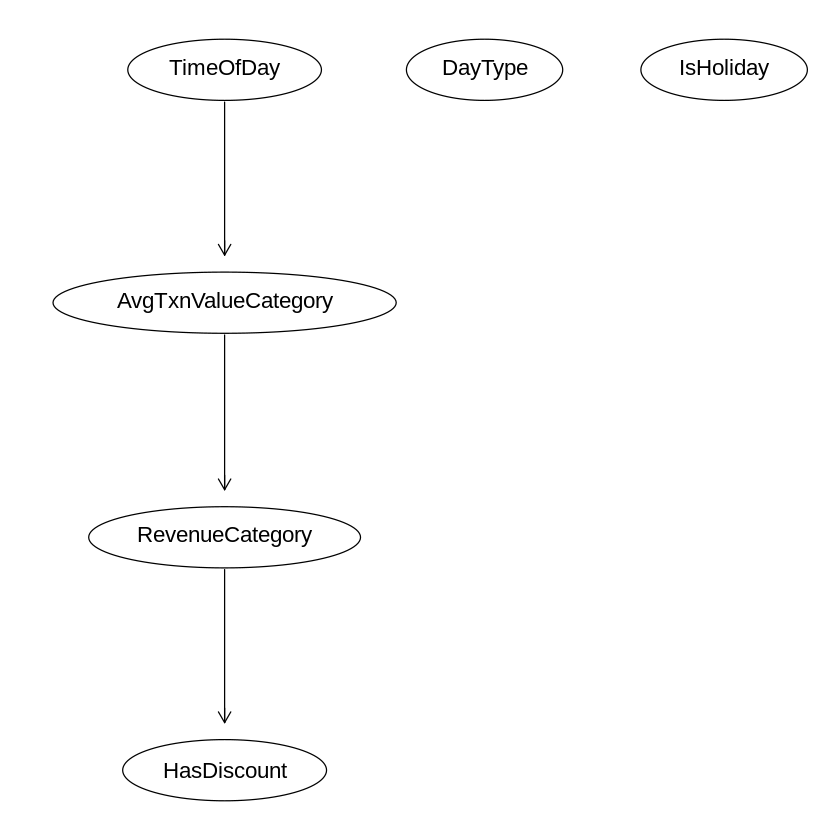

In [88]:
set.seed(123)
train_indices <- sample(1:nrow(bn_data_final), size = 0.9 * nrow(bn_data_final))
training_set <- bn_data_final[train_indices, ]
test_set <- bn_data_final[-train_indices, ]

hc_structure_final <- hc(training_set)
graphviz.plot(hc_structure_final, shape = "ellipse")

fitted_model_final <- bn.fit(hc_structure_final, data = training_set)
predictions_final <- predict(fitted_model_final,
                             node = "RevenueCategory",
                             data = test_set)

confusion_matrix_final <- table(Predicted = predictions_final, Actual = test_set$RevenueCategory)
accuracy_final <- sum(diag(confusion_matrix_final)) / sum(confusion_matrix_final)

print("--- Kết quả trên Test Set (mô hình đầy đủ biến cuối cùng) ---")
print("Bảng so sánh kết quả (Confusion Matrix):")
print(confusion_matrix_final)
print(paste("=> Độ chính xác:", paste0(round(accuracy_final * 100, 2), "%")))

### 4.3 Mô hình DBN với biến trễ

[1] "Đang vẽ đồ thị mạng Chuyên gia (đầy đủ biến)..."
[1] "--- Kết quả trên Test Set cho mô hình DBN đầy đủ ---"
[1] "Bảng so sánh kết quả (Confusion Matrix):"
         Actual
Predicted High Low Medium Zero
   High     31   0      3    0
   Low       0  34      6    1
   Medium    5   5     23    0
   Zero      0   0      0  196
[1] "=> Độ chính xác: 93.42%"


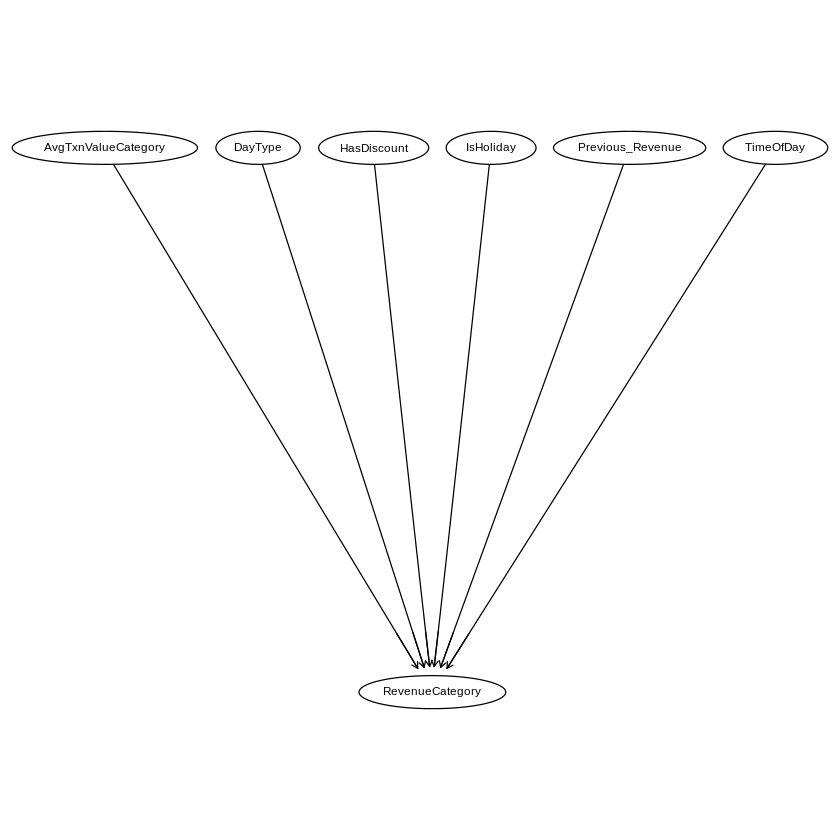

In [89]:
# Tạo dataframe cho DBN với biến trễ
dbn_data_full <- data.frame(
  HasDiscount = as.factor(df_final$HasDiscount),
  TimeOfDay   = as.factor(df_final$TimeOfDay),
  DayType     = as.factor(df_final$DayType),
  IsHoliday = as.factor(df_final$IsHoliday),
  AvgTxnValueCategory = as.factor(df_final$AvgTxnValueCategory),
  RevenueCategory = as.factor(df_final$RevenueCategory),
  # Tạo biến trễ cho RevenueCategory
  Previous_Revenue = as.factor(lag(df_final$RevenueCategory))
)
dbn_data_full <- na.omit(dbn_data_full)
dbn_data_full <- droplevels(dbn_data_full)


# 1. Chia dữ liệu
set.seed(123)
train_indices <- sample(1:nrow(dbn_data_full), size = 0.9 * nrow(dbn_data_full))
training_set <- dbn_data_full[train_indices, ]
test_set <- dbn_data_full[-train_indices, ]

# 2. Định nghĩa cấu trúc DBN đầy đủ
# Tất cả các biến khác và biến trễ đều ảnh hưởng đến RevenueCategory
predictors <- setdiff(names(training_set), "RevenueCategory")
dbn_full_structure_string <- paste0("[", paste(predictors, collapse="]["), "]",
                                    "[RevenueCategory|", paste(predictors, collapse=":"), "]")

dbn_full_structure <- model2network(dbn_full_structure_string)
fitted_dbn_full <- bn.fit(dbn_full_structure, data = training_set)

# 3. Dự đoán trên tập test_set
predictions_dbn_full <- predict(fitted_dbn_full,
                                node = "RevenueCategory",
                                data = test_set)

print("Đang vẽ đồ thị mạng Chuyên gia (đầy đủ biến)...")
graphviz.plot(dbn_full_structure, shape = "ellipse")

# 4. Đánh giá độ chính xác
confusion_matrix_dbn_full <- table(Predicted = predictions_dbn_full, Actual = test_set$RevenueCategory)
accuracy_dbn_full <- sum(diag(confusion_matrix_dbn_full)) / sum(confusion_matrix_dbn_full)

print("--- Kết quả trên Test Set cho mô hình DBN đầy đủ ---")
print("Bảng so sánh kết quả (Confusion Matrix):")
print(confusion_matrix_dbn_full)
print(paste("=> Độ chính xác:", paste0(round(accuracy_dbn_full * 100, 2), "%")))

### 4.5 Mô hình DBN với Hill Climd K-Fold = 5

In [90]:
bn_data_to_evaluate <- dbn_data_full

print(paste("Thực hiện Cross-Validation trên", nrow(bn_data_to_evaluate), "dòng dữ liệu."))

# 2. Tạo ra 5-fold có phân tầng (stratified)
set.seed(123)
folds <- createFolds(bn_data_to_evaluate$RevenueCategory, k = 5, list = TRUE, returnTrain = FALSE)

# Tạo một vector để lưu trữ kết quả độ chính xác của mỗi fold
accuracies <- c()

# 3. Bắt đầu vòng lặp Cross-Validation
for(i in 1:5){

  # Chia dữ liệu cho fold hiện tại
  test_indices <- folds[[i]]
  test_set <- bn_data_to_evaluate[test_indices, ]
  training_set <- bn_data_to_evaluate[-test_indices, ]

  # Huấn luyện mô hình hc trên tập training của fold này
  hc_structure <- hc(training_set)
  fitted_model <- bn.fit(hc_structure, data = training_set)

  # Dự đoán trên tập test của fold này
  predictions <- predict(fitted_model, node = "RevenueCategory", data = test_set)

  # Tính toán và lưu lại độ chính xác
  accuracy <- sum(predictions == test_set$RevenueCategory) / nrow(test_set)
  accuracies <- c(accuracies, accuracy)

  print(paste("Độ chính xác của Fold", i, ":", paste0(round(accuracy * 100, 2), "%")))
}

# 4. Tính toán độ chính xác trung bình
mean_accuracy <- mean(accuracies)

print("--- Kết quả cuối cùng của 5-fold Cross-Validation ---")
print(paste("=> Độ chính xác dự đoán trung bình:", paste0(round(mean_accuracy * 100, 2), "%")))

[1] "Thực hiện Cross-Validation trên 3063 dòng dữ liệu."
[1] "Độ chính xác của Fold 1 : 91.83%"
[1] "Độ chính xác của Fold 2 : 89.4%"
[1] "Độ chính xác của Fold 3 : 87.95%"
[1] "Độ chính xác của Fold 4 : 91.82%"
[1] "Độ chính xác của Fold 5 : 89.56%"
[1] "--- Kết quả cuối cùng của 5-fold Cross-Validation ---"
[1] "=> Độ chính xác dự đoán trung bình: 90.11%"


##6. So sánh kết quả

In [91]:
# --- Cell 1: Suy diễn xác suất ---

# Giả định bạn đã có mô hình "fitted_dbn_full" và dữ liệu "training_set"
# từ các bước trước. Nếu chưa, bạn cần chạy lại cell mã cuối cùng.

# Câu hỏi 1: "Vào một ngày cuối tuần (Weekend), nếu có giảm giá (Yes) và
# doanh thu giờ trước đó là Cao (High), thì xác suất doanh thu giờ này
# cũng là Cao (High) là bao nhiêu?"
set.seed(101) # cpquery là một thuật toán mô phỏng, cần set.seed để có kết quả nhất quán
prob_q1 <- cpquery(fitted_dbn_full,
                   event = (RevenueCategory == "High"),
                   evidence = (DayType == "Weekend" & HasDiscount == "Yes" & Previous_Revenue == "High"))

print("--- SUY DIỄN ---")
print(paste("Câu hỏi 1: P(Revenue = High | Day = Weekend, Discount = Yes, Previous Revenue = High) =",
            round(prob_q1 * 100, 2), "%"))


# Câu hỏi 2: "Vào một ngày trong tuần (Weekday), buổi sáng (Morning) và
# không có giảm giá (No), thì xác suất không có doanh thu (Zero) là bao nhiêu?"
set.seed(102)
prob_q2 <- cpquery(fitted_dbn_full,
                   event = (RevenueCategory == "Zero"),
                   evidence = (DayType == "Weekday" & TimeOfDay == "Morning" & HasDiscount == "No"))

print(paste("Câu hỏi 2: P(Revenue = Zero | Day = Weekday, TimeOfDay = Morning, Discount = No) =",
            round(prob_q2 * 100, 2), "%"))

[1] "--- SUY DIỄN ---"
[1] "Câu hỏi 1: P(Revenue = High | Day = Weekend, Discount = Yes, Previous Revenue = High) = 29.41 %"
[1] "Câu hỏi 2: P(Revenue = Zero | Day = Weekday, TimeOfDay = Morning, Discount = No) = 61.52 %"
